<a href="https://colab.research.google.com/github/Guasong/CS125FinalProject/blob/master/TDDB_Notebook_Via_to_line_(BEOL).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoder

## Imports

In [1]:
!pip install reliability

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.8/247.8 KB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.0/89.0 KB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 77.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.0/296.0 KB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 KB 50.2 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4048 sha256=6c05a2a4e223329aa7bf0801357bbb7701fc3fdc8792e426c71801ccb2d2909c
  Stored in directory: /root/.cache/pip/wheels/16/a2/b6/582cfdfbeeccd469504a01af3bb952fd9e7eccba40995eafea
  Created wheel for mplcursors: filename=mplcursors-0.5.2-py3-none-any.whl size=21069 sha256=965dc6067d7eeabf26bd55b2fc24c37982d73e68d70925e34ff

In [1]:
import numpy as np                             # for fast array manipulation
import pandas as pd
import random
import torch                                   # Pytorch
import torchvision                             # contains image datasets and many functions to manipulate images
import torchvision.transforms as transforms    # to normalize, scale etc the dataset
from torch.utils.data import DataLoader        # to load data into batches (for SGD)
from torch.utils.data import Dataset        # to load data into batches (for SGD)
from torchvision.utils import make_grid        # Plotting. Makes a grid of tensors
from torchvision.datasets import MNIST         # the classic handwritten digits dataset
import matplotlib.pyplot as plt                # to plot our images
import torch.nn as nn                          # Class that implements a model (such as a Neural Network)
import torch.nn.functional as F                # contains activation functions, sampling layers and more "functional" stuff
import torch.optim as optim                    # For optimization routines such as SGD, ADAM, ADAGRAD, etc
from scipy import stats
from torch.distributions import Weibull

## Set up the Device (GPU or CPU)

In [2]:
device = torch.device("cpu")
device

device(type='cpu')

In [3]:
# # Set up Transformations (0-1 Scaling only)
# # DO NOT NORMALIZE WITH VAE. NORMALIZING WITH MEAN 0 AND STD 1 MEANS WE WILL HAVE
# # NEGATIVE PIXEL VALUES AND THIS IS NOT ALLOWED SINCE WE ARE USING A BINARY
# # CROSS ENTROPY LOSS (I.E. BERNOULLI). WE NEED THE PIXEL VALUES TO BE INTERPRETABLE AS 
# # PROBABILITIES 
# t = transforms.Compose([
#                         transforms.ToTensor()
# ])

# # Use transformation for both training and test set
# trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=t)
# testset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=t)

# # Load train and test set
# trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
# testloader  = DataLoader(testset, batch_size=batch_size, shuffle=True)

## Load MNIST DataSet

In [46]:
from google.colab import files
uploaded = files.upload()

Saving dataset4.csv to dataset4.csv


## Global Settings

In [52]:
a = torch.tensor([1,2])
x = a.reshape([2,1])
b = torch.tensor([[1,2,3,4],[1,2,3,4]])
print(x)

tensor([[1],
        [2]])


In [53]:
batch_size = 2      # How many images to use for a SGD update
L = 1                 # Samples per data point. See section "Likelihood Lower Bound".
e_hidden = 20        # Number of hidden units in the encoder. Chosen based on AEVB paper page 7, section "Marginal Likelihood"
e2_hidden = 25       # Second layer hidden in encoder
e3_hidden = 20        # Third layer
d_hidden = 500        # Number of hidden units in the decoder. Chosen based on AEVB paper page 7, section "Marginal Likelihood"
d2_hidden = 250       # Second layer hidden in decoder
d3_hidden = 50        # Third layer
latent_dim = 10        # Chosen based on AEVB paper, page 7, section "Marginal Likelihood"
gaussian_num = 2      # Number of gaussian distributions to mix
learning_rate = 0.0003 # For SGD
weight_decay = 1e-5   # For SGD
epochs = 300          # Number of sweeps through the whole dataset, also called epochs
input_size = 7
# area1_point = 718
# area2_point = 723
# area3_point = 729
# censor_point_0=22
# censor_point_1=7
# censor_point_2=6

area1_point = 800
area2_point = 800
area3_point = 800
censor_point_0=6
censor_point_1=0
censor_point_2=0

censor_percent_0=censor_point_0/area1_point
censor_percent_1=censor_point_1/area2_point
censor_percent_2=censor_point_2/area3_point
m=20
loss_tuning = 3
mu_p=torch.tensor([18.8, 18.7])
var_p = torch.tensor([0.2, 1])
logvar_p=torch.log(var_p)
pi_p = torch.tensor([0.5, 0.5])
logpi_p=torch.log(torch.tensor([0.5, 0.5]))

In [54]:
from math import ceil
from math import floor
rng = np.random.default_rng()

In [209]:
import io
df = pd.read_csv(io.StringIO(uploaded['dataset4.csv'].decode('utf-8')), index_col=None, header=None)
tbd_max = df.iloc[:,:3].max().max()
tbd_min = df.iloc[:,:3].min().min()
i_max = df.iloc[:,3:6].max().max()
i_min = df.iloc[:,3:6].min().min()
class MyDataset(Dataset):
  def __init__(self,df):
 
    area1=df.iloc[censor_point_0:area1_point,0].values.flatten()
    current1=df.iloc[censor_point_0:area1_point,3].values.flatten()
    x=np.stack((area1, current1), axis=1)[:area1_point]
    np.random.shuffle(x)
    random_point_num = ceil(len(x)/input_size)*input_size-len(x)
    random_sample = rng.choice(x, random_point_num, replace=False)
    x=np.append(random_sample, x, axis=0)
    current1=x[:,1].reshape(-1,input_size)
    area1=x[:,0].reshape(-1,input_size)

    area2=df.iloc[censor_point_1:area2_point,1].values.flatten()
    current2=df.iloc[censor_point_1:area2_point,4].values.flatten()
    x=np.stack((area2, current2), axis=1)
    np.random.shuffle(x)
    random_point_num = ceil(len(x)/input_size)*input_size-len(x)
    random_sample = rng.choice(x, random_point_num, replace=False)
    x=np.append(random_sample, x, axis=0)
    current2=x[:,1].reshape(-1,input_size)
    area2=x[:,0].reshape(-1,input_size)


    area3=df.iloc[censor_point_2:area3_point,2].values.flatten()
    current3=df.iloc[censor_point_2:area3_point,5].values.flatten()
    x=np.stack((area3, current3), axis=1)
    np.random.shuffle(x)
    random_point_num = ceil(len(x)/input_size)*input_size-len(x)
    random_sample = rng.choice(x, random_point_num, replace=False)
    x=np.append(random_sample, x, axis=0)
    current3=x[:,1].reshape(-1,input_size)
    area3=x[:,0].reshape(-1,input_size)

    y1=np.full(area1.shape[0], 100)
    y2=np.full(area2.shape[0], 10)
    y3=np.full(area3.shape[0], 1)
    
    x = np.append(area1, area2, axis=0)
    y = np.append(y1, y2, axis=0)
    w = np.append(current1, current2, axis=0)
    
    x = np.append(x, area3, axis=0)
    y = np.append(y, y3, axis=0)
    w = np.append(w, current3, axis=0)

#   Train without area1
    # x = np.append(area2, area3, axis=0)
    # y = np.append(y2, y3, axis=0)
    # w = np.append(current2, current3, axis=0)
    
#   adjust size to match epoch

    x = np.append(x, x, axis=0)
    y = np.append(y, y, axis=0)
    w = np.append(w, w, axis=0)


    self.x_train=torch.tensor(x,dtype=torch.float32)
    self.y_train=torch.tensor(y,dtype=torch.float32)
    self.w_train=torch.tensor(w,dtype=torch.float32)
 
  def __len__(self):
    return len(self.y_train)
   
  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx],self.w_train[idx]

myDs=MyDataset(df)
trainloader=DataLoader(myDs,batch_size=batch_size,shuffle=True)

## Encoder

In [210]:
# My custom layer
class constant_layer(nn.Module):
  def __init__(self, in_features, out_features, bias=True):
    super().__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.bias = torch.nn.Parameter(torch.randn(out_features))
  def forward(self, input):
    return self.bias

In [219]:
class Encoder(nn.Module):
  def __init__(self):
    """
    Encoder Network. Must inherit from `nn.Module` provided by Pytorch. We only need to define 2 things:
    
    1) The components of the network (layers, activation functions, etc). This is done in __init__().
    2) How the network uses such components to transform the network input into an output. This is done in a method called `forward()`.
    """
    super(Encoder, self).__init__()
    # Define Fully-Connected FeedForward Connections
    self.hidden = nn.Linear(in_features=input_size*2+1, out_features=e_hidden)
    self.hidden2 = nn.Linear(in_features=e_hidden, out_features=e2_hidden)
    self.hidden3 = nn.Linear(in_features=e2_hidden, out_features=e3_hidden)
    self.area_hidden = nn.Linear(in_features=2, out_features=e_hidden)
    self.area_hidden2 = nn.Linear(in_features=e_hidden, out_features=e2_hidden)
    self.area_hidden3 = nn.Linear(in_features=e2_hidden, out_features=e3_hidden)
    # We need two separate layers. One is used for mu one is used for logvar.
    self.logmu1_layer     = nn.Linear(in_features=e3_hidden, out_features=1)
    self.logvar1_layer = nn.Linear(in_features=e3_hidden, out_features=1)
    self.logmu2_layer     = nn.Linear(in_features=e3_hidden, out_features=1)
    self.logvar2_layer = nn.Linear(in_features=e3_hidden, out_features=1)
    self.pi_layer     = nn.Linear(in_features=e3_hidden, out_features=1)   # only need one mixing parameter for bimodal GMM
    self.loga_layer     = nn.Linear(in_features=e3_hidden, out_features=1)                # two out features for a and b
    self.logb_layer     = nn.Linear(in_features=e3_hidden, out_features=1)                # two out features for a and b
  def forward(self, x, area, current):
    """Defines how the network transforms the input x into an encoded representation."""
    # Pass input through the first set of connections
    x = (x-tbd_min)/(tbd_max-tbd_min)
    current = (current-i_min)/(i_max-i_min)
    x, indices = torch.sort(x)
    for i in range(len(x)):
      current[i] = current[i][indices[i]]
    x = torch.cat((x,current,torch.log10(area).reshape(batch_size,1)), 1)
    x1 = F.relu(self.hidden(x))
    x2 = F.relu(self.hidden2(x1))
    x3 = F.relu(self.hidden3(x2))
    # a = F.relu(self.area_hidden(torch.log10(a)))
    # a = F.relu(self.area_hidden2(a))
    # a = F.relu(self.area_hidden3(a))
    y = x3
    # Now pass it to one set of connections to get mu, and to another set of connections 
    # to get logvar
    pi = self.pi_layer(y)

    a = self.loga_layer(y).repeat(1,input_size)
    a = torch.exp(a)
    b = self.logb_layer(y).repeat(1,input_size)
    b = torch.exp(b)
    # a = self.loga_layer(y).repeat(1,input_size)
    # a = F.sigmoid(a)
    # b = self.logb_layer(y).repeat(1,input_size)
    # b = F.sigmoid(b)
    logmu1 = self.logmu1_layer(y).repeat(1,input_size)+3
    logvar1 = self.logvar1_layer(y).repeat(1,input_size)+1.5
    logmu2 = self.logmu2_layer(y).repeat(1,input_size)+3
    logvar2 = self.logvar2_layer(y).repeat(1,input_size)+1.5
    return logmu1, logvar1, logmu2, logvar2, torch.sigmoid(pi), a, b

## Decoder

In [220]:
class Decoder(nn.Module):
  def __init__(self, T_630, A0, m=20.0):
    """
    Decoder Network. Works similarly to the encoder, except it takes an input from the latent space
    and then outputs an image.
    """
    super(Decoder, self).__init__()
    # Define Fully-Connected FeedForward Connections
    # self.hidden = nn.Linear(in_features=latent_dim, out_features=d_hidden)
    # self.batchnorm = nn.Batchnorm1d(num_features=d3_hidden)
    # self.hidden2 = nn.Linear(in_features=d_hidden, out_features=d2_hidden)
    # self.hidden3 = nn.Linear(in_features=d2_hidden, out_features=d3_hidden)
    # Second set of FC connections. Here we only want one output
    # self.output_layer = nn.Linear(in_features=d_hidden, out_features=input_size)
    self.T_630 = T_630
    self.m = 20.0
    self.A0 = A0

  def forward(self, z, a, b, mu, A):
    """Defines how the network transforms the latent input z into a flatten image."""
    # Notice that we use a sigmoid function at the end to restrict output values between 
    # 0 and 1 so they can be interpreted as probabilities (?)
    # Reason for unphysical!!!!
    beta = a+b*z*0.3*0.5
    area = A.repeat(input_size)
    area = area.reshape((-1, batch_size)).T
    T63 = self.T_630*(self.A0/area)**(1/beta)*(z/mu)**self.m
    return beta, T63

## Variational Auto-Encoder

In [221]:
class VAE(nn.Module):
  def __init__(self, T_630, A0):
    """Puts together Encoder & Decoder with the reparametrization trick."""
    super(VAE, self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder(T_630, A0, m=20.0)

  def sample_latent(self, logmu1, logvar1, logmu2, logvar2, pi):
    # Get standard normal in the shape of mu  
    eps1 = torch.randn(batch_size, input_size)
    eps2 = torch.randn(batch_size, input_size)
    # Use logarithmic properties to transform logvar to std. Then multiply
    # and sum by latent mu
    # mu = batch*1
    mu1 = torch.exp(logmu1)
    mu2 = torch.exp(logmu2)
    first_z = eps1.mul(torch.exp(0.5*logvar1)).add_(mu1)
    second_z = eps2.mul(torch.exp(0.5*logvar2)).add_(mu2)
    mixed_z = torch.tensor([])
    select = torch.rand(batch_size, 1)
    for i in range(batch_size):
      if select[i][0] < pi[i][0]:
        mixed_z = torch.cat((mixed_z, first_z[i]), 0)
      else:
        mixed_z = torch.cat((mixed_z, second_z[i]), 0)
    mixed_z = mixed_z.reshape(batch_size, input_size)
    gmm_mu = mu1*pi+mu2*(1-pi)
    var1 = torch.exp(logvar1)
    var2 = torch.exp(logvar2)
    gmm_var = var1.mul(pi)+var2.mul(1-pi)+pi*(1-pi)*((mu1-mu2)**2)
    gmm_logvar = torch.log(gmm_var)
    return mixed_z, gmm_mu, gmm_logvar

  def forward(self, x, A, current):
    """Transforms image into latent and then back to its reconstruction."""
    # Feed image to encoder. Obtain mean and logvar for the latent space
    logmu1, logvar1, logmu2, logvar2, latent_pi, a, b = self.encoder(x.view(-1, input_size), A, current)
    # Sample from the latent space with the give mean and variance using the 
    # reparametrization trick
    z, gmm_mu, gmm_logvar = self.sample_latent(logmu1, logvar1, logmu2, logvar2, latent_pi)
    # problem
    # Decode the latent representation
    beta, T63 = self.decoder(z.view(-1, input_size), a, b, gmm_mu, A)
    return beta, T63, logmu1, logmu2, logvar1, logvar2, latent_pi, a, b   


## VAE Loss Function (KL + Reconstruction Loss)
Remember from the [slides](https://neuralnetworksbristol.netlify.app/VAE_Mauro.pdf) that maximizing the evidence can be approximately done by maximizing the ELBO (Evidence Lower Bound) which can be written as a difference of two terms:

$$
\newcommand{\Ebb}{\mathbb{E}}
\newcommand{\vect}[1]{\boldsymbol{\mathbf{#1}}}
\newcommand{\vphi}{\vect{\phi}}
\newcommand{\vtheta}{\vect{\theta}}
\newcommand{\vx}{\vect{x}}
\newcommand{\vz}{\vect{z}}
\newcommand{\kl}[2]{\text{KL}(#1\,\,||\,\,#2)}
\newcommand{\encoder}{q_{\vphi}(\vz \mid \vx)}
\newcommand{\elbo}{\mathcal{L}_{\theta, \vphi}(\vx)}
\newcommand{\vepsilon}{\vect{\epsilon}}
\newcommand{\iid}{\overset{\text{i.i.d.}}{\sim}}
\elbo =
\underbrace{\Ebb_{q_{\vphi}}\left[\log p_{\vtheta}(\vx\mid \vz)\right]}_{\text{Expected Log-Likelihood}} - \underbrace{\kl{\encoder}{p_{\vtheta}(\vz)}}_{\text{Regularization Term}}
$$

In the case of both $q_{\vphi}$ and $\encoder$ being Gaussians the [AEVB paper](https://arxiv.org/pdf/1312.6114.pdf) shows that the following formula is available

$$
-\kl{q_{\vphi}}{\encoder} = \frac{1}{2}\sum_{j=1}^J \left[1 + \log\sigma_j^2  - \mu_j^2 - \sigma_j^2\right]
$$
where $J$ is the dimensionality of $\vz$ which, in our case, is denoted `latent_dim`.

Then an unbiased estimate for the Objective is given below:

$$
\widetilde{\mathcal{L}}_{\vtheta, \vphi}(\vx) = \displaystyle \frac{1}{L}\sum_{i=1}^L \left[\log p_{\vtheta}(\vx \mid g_{\vphi}(\vepsilon^{(i)}, \vx))\right] - \frac{1}{2}\sum_{j=1}^J \left[1 + \log\sigma_j^2  - \mu_j^2 - \sigma_j^2\right] \qquad \text{where } \vepsilon^{(i)} \iid \mathcal{N}(\vect{0}, \vect{I})
$$

Where $L=$ `L` and $J=$ `latent_dim`. 

Recall from Slide $14$ that in the case of Bernoulli variables the log-likelihood becomes

$$
\log p_{\vtheta}(\vx\mid \vz) = \sum_{j} x_j \log p_j + (1 - x_j) \log(1 - p_j)
$$
Since we want our pixel values to be between `0` and `1` this is exactly what we are looking for and thankfully is already implemented in Pytorch under the name of `binary_crossentropy`.

In [222]:
def vae_loss(image, beta, T63, logmu1, logmu2, logvar1, logvar2, pi):
  """Loss for the Variational AutoEncoder."""
  # Compute the binary_crossentropy.
  # Notice that we reshape them because in practice we don't receive just 1 image and 1 reconstruction, but we receive a whole batch!
  # reconstruction_loss = F.cross_entropy(input=reconstruction.view(-1, input_size), target=image.view(-1, input_size), reduction='sum')
  reconstruction_loss = torch.sum(torch.log(beta)-beta*torch.log(T63)+(beta-1)*torch.log(image)-(image/T63)**beta)
  # Compute KL divergence using formula (closed-form)
  mu1=torch.exp(logmu1)
  mu2=torch.exp(logmu2)
  pi1 = pi
  pi2 = 1-pi
  var1 = torch.exp(logvar1)
  var2 = torch.exp(logvar2)
  kl1 = logvar_p[0]+logpi_p[0]-logvar1-torch.log(pi1)-0.5+0.5*(var1**2+(mu1-mu_p[0])**2)/var_p[0]**2
  kl2 = logvar_p[1]+logpi_p[1]-logvar2-torch.log(pi2)-0.5+0.5*(var2**2+(mu2-mu_p[1])**2)/var_p[1]**2
  kl = torch.sum(kl1*pi+kl2*(1-pi))  # upperbound mentioned by Olsen's paper
  MSE_loss = torch.sum((mu1*pi1+mu2*pi2-torch.tensor([32]).repeat(batch_size*input_size).reshape(batch_size, input_size)))**2
  total_loss = abs(reconstruction_loss)+10*MSE_loss
  return total_loss, MSE_loss
  # return total_loss, reconstruction_loss, kl

## VAE Training

In [223]:
# Instantiate VAE
vae = VAE(T_630=217, A0=10.0)
# vae = VAE(T_630=657.5, A0=10.0)
# vae = VAE(T_630=1163.0, A0=1.0)
# Pass VAE to the device (GPU or CPU)
vae = vae.to(device)

# Use Stochastic Gradient Descent as optimizer
optimizer = optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=weight_decay)
# Set VAE to training mode
vae.train()

VAE(
  (encoder): Encoder(
    (hidden): Linear(in_features=15, out_features=20, bias=True)
    (hidden2): Linear(in_features=20, out_features=25, bias=True)
    (hidden3): Linear(in_features=25, out_features=20, bias=True)
    (area_hidden): Linear(in_features=2, out_features=20, bias=True)
    (area_hidden2): Linear(in_features=20, out_features=25, bias=True)
    (area_hidden3): Linear(in_features=25, out_features=20, bias=True)
    (logmu1_layer): Linear(in_features=20, out_features=1, bias=True)
    (logvar1_layer): Linear(in_features=20, out_features=1, bias=True)
    (logmu2_layer): Linear(in_features=20, out_features=1, bias=True)
    (logvar2_layer): Linear(in_features=20, out_features=1, bias=True)
    (pi_layer): Linear(in_features=20, out_features=1, bias=True)
    (loga_layer): Linear(in_features=20, out_features=1, bias=True)
    (logb_layer): Linear(in_features=20, out_features=1, bias=True)
  )
  (decoder): Decoder()
)

In [224]:
# Store all losses here
losses = []
mse_losses = []
reconstruction_losses = []
for epoch in range(epochs):
  # Put a zero into losses. This is where we will cumulatively sum all the losses
  # from each batch. After all batches are done, we will divide by the number of batches
  # to obtain the average loss per batch
  losses.append(0)
  mse_losses.append(0)
  reconstruction_losses.append(0)

  # To compute the number of batches (since it varies depending on dataset size)
  # update a counter variable
  number_of_batches = 0

  # Grab the batch, we are only interested in images not on their labels
  for images, area, current in trainloader:
    # Store image batch to device
    images = images.to(device)

    # Set previous gradients to zero
    optimizer.zero_grad()

    # Feed images through the VAE to obtain their reconstruction
    beta, T63, logmu1, logmu2, logvar1, logvar2, latent_pi, a, b = vae(images, area, current)

    # Compare reconstruction and images via the loss function
    # loss, kl, reconstruction_loss = vae_loss(images, beta, T63, logmu1, logmu2, logvar1, logvar2, latent_pi)
    
    loss, mse = vae_loss(images, beta, T63, logmu1, logmu2, logvar1, logvar2, latent_pi)
    
    # Backpropagate the loss. Before doing that, make sure all previously stored gradients are zero (e.g. from previous iterations)
    loss.backward()


    # Use the accumulated gradients to do a step in the right direction
    optimizer.step()

    # Add loss to the cumulative sum
    losses[-1] += loss.item()        #.item() grabs the value in a tensor with only 1 value
    mse_losses[-1] += mse.item()
    # reconstruction_losses[-1] += reconstruction_loss.item()
    number_of_batches += 1
  
  # At the end of all batches divide the total loss for this epoch by the number of 
  # batches to obtain an average loss per batch
  losses[-1] /= number_of_batches
  # kl_losses[-1] /= number_of_batches
  # reconstruction_losses[-1] /= number_of_batches
  print('Epoch [%d / %d] average total error: %f , average MSE loss: %f , average reconstruction error: %f' % (epoch+1, epochs, losses[-1], mse_losses[-1], losses[-1]))    


Epoch [1 / 300] average total error: 1259179844775.709717 , average MSE loss: 11785312.765625 , average reconstruction error: 1259179844775.709717
Epoch [2 / 300] average total error: 131737313879993.000000 , average MSE loss: 11698574.761719 , average reconstruction error: 131737313879993.000000
Epoch [3 / 300] average total error: 47761369236.271896 , average MSE loss: 11512268.617188 , average reconstruction error: 47761369236.271896
Epoch [4 / 300] average total error: 47763878377.715660 , average MSE loss: 11488964.988281 , average reconstruction error: 47763878377.715660
Epoch [5 / 300] average total error: 310768039043.136475 , average MSE loss: 11458496.560547 , average reconstruction error: 310768039043.136475
Epoch [6 / 300] average total error: 2824966193.653162 , average MSE loss: 11439332.617188 , average reconstruction error: 2824966193.653162
Epoch [7 / 300] average total error: 477139407353.955139 , average MSE loss: 11343059.986328 , average reconstruction error: 47713

KeyboardInterrupt: ignored

## Visualizing Losses

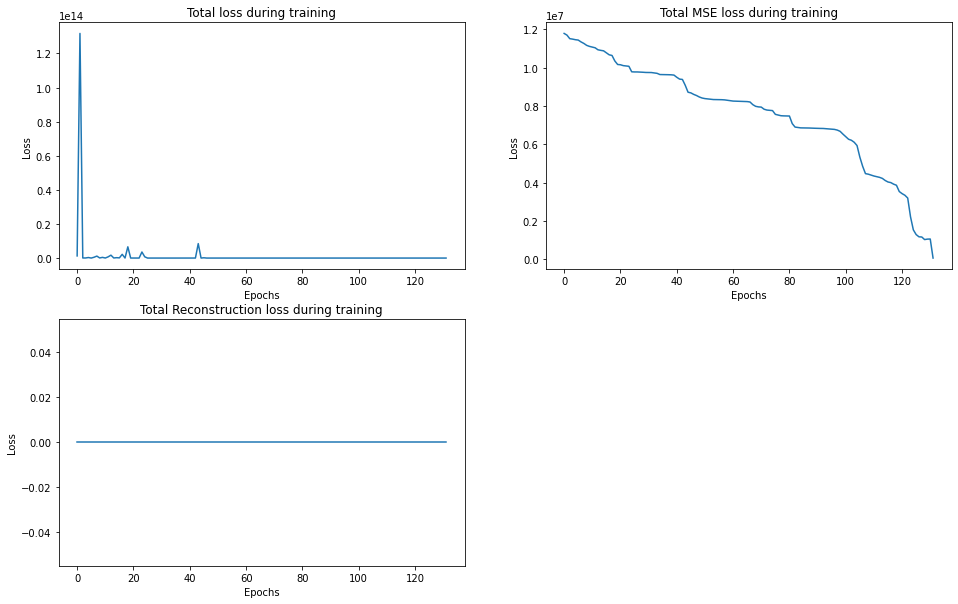

In [225]:
fig = plt.figure(figsize=(16, 10))
plt.subplot(221)
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Total loss during training')
plt.subplot(222)
plt.plot(mse_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Total MSE loss during training')
plt.subplot(223)
plt.plot(reconstruction_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Total Reconstruction loss during training')
plt.show()

## Evaluate VAE on Test Set

To understand why we need to use `.eval()` have a look [here](https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch)

In [226]:
# Set VAE to evaluation mode
vae.eval()

# As we did in training mode, simply store the loss and number of batches
# Now we only need one number because we don't have epochs
test_loss, number_of_batches = 0.0, 0
learned_logmu1, learned_logmu2, learned_logvar1, learned_logvar2, learned_pi, learned_a, learned_b = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
for test_images, area, current in trainloader:

  # Do not track gradients
  with torch.no_grad():

    # Send images to the GPU/CPU
    test_images = test_images.to(device)
    # Feed images through the VAE to obtain their reconstruction
    beta, T63, logmu1, logmu2, logvar1, logvar2, latent_pi, a, b = vae(test_images, area, current)

    # Compute reconstruction loss
    loss, mse_loss = vae_loss(images, beta, T63, logmu1, logmu2, logvar1, logvar2, latent_pi)

    print("beta: ", beta)
    print("T63: ", T63)
    print("label: ", area)

    # Cumulative loss & Number of batches
    test_loss += loss.item()
    learned_logmu1 += torch.sum(logmu1)
    learned_logmu2 += torch.sum(logmu2)
    learned_logvar1 += torch.sum(logvar1)
    learned_logvar2 += torch.sum(logvar2)
    learned_pi += torch.sum(latent_pi)
    learned_a += torch.sum(a)
    learned_b += torch.sum(b)
    number_of_batches += 1

# Now divide by number of batches to get average loss per batch
test_loss /= number_of_batches
learned_logmu1 /= number_of_batches*input_size*batch_size
learned_logmu2 /= number_of_batches*input_size*batch_size
learned_logvar1 /= number_of_batches*input_size*batch_size
learned_logvar2 /= number_of_batches*input_size*batch_size
learned_pi /= number_of_batches*input_size*batch_size
learned_a /= number_of_batches*input_size*batch_size
learned_b /= number_of_batches*input_size*batch_size
learned_mu1=torch.exp(learned_logmu1).item()
learned_mu2=torch.exp(learned_logmu2).item()
learned_var1=torch.exp(learned_logvar1).item()
learned_var2=torch.exp(learned_logvar2).item()
learned_pi = learned_pi.item()
print('average reconstruction error: %f' % (test_loss))


beta:  tensor([[2.3687, 2.3668, 2.2168, 2.3749, 2.1713, 2.4104, 2.2363],
        [1.9778, 1.9371, 1.9105, 1.9536, 1.7616, 1.8533, 1.8504]])
T63:  tensor([[481.5851, 470.5987,  73.7068, 517.9283,  40.5443, 782.0988,  94.7594],
        [580.6821, 320.8796, 215.7728, 408.9507,  20.0551,  89.5329,  85.4310]])
label:  tensor([ 10., 100.])
beta:  tensor([[2.9153, 2.9983, 2.9682, 3.0464, 2.9403, 2.9996, 2.6797],
        [1.7750, 1.8079, 1.7587, 1.7905, 1.7661, 1.8066, 1.8245]])
T63:  tensor([[ 856.4897, 1843.3221, 1401.1749, 2836.1562, 1082.6638, 1865.4122,
           81.3234],
        [  24.4731,   42.1223,   18.5893,   31.6824,   21.0637,   41.2312,
           55.1070]])
label:  tensor([  1., 100.])
beta:  tensor([[2.0240, 1.9013, 1.8286, 1.8833, 1.9331, 1.9826, 1.8224],
        [2.6021, 2.8126, 2.6011, 2.8281, 3.0667, 2.9922, 2.8160]])
T63:  tensor([[1126.0551,  189.4552,   61.0359,  144.0956,  305.1115,  628.0026,
           55.2361],
        [  39.8077,  359.6970,   39.3643,  418.7869, 3

In [245]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

ernest=False
area_choose=0

if area_choose == 0:
  generate_area=100.0
  num_of_points=area1_point
  censor_percent=censor_percent_0
elif area_choose == 1:
  generate_area=10.0
  num_of_points=area2_point
  censor_percent=censor_percent_1
else:
  generate_area=1.0
  num_of_points=area3_point
  censor_percent=censor_percent_2

ernest_a=torch.tensor(-0.2)
ernest_b=torch.tensor(0.07/0.3)
ernest_std=torch.tensor(2.23)
ernest_mean=torch.tensor(26)
means = learned_mu1, learned_mu2
if ernest==True:
  stdevs = torch.log(ernest_std)
else:
  stdevs = learned_var1**0.5, learned_var2**0.5
weights = learned_pi, 1-learned_pi
print(means, stdevs, weights, learned_a, learned_b)
def draw_gmm(means, stdevs, weights, x, label='pdf'):
  pdfs = [p * ss.norm.pdf(x, mu, sd) for mu, sd, p in zip(means, stdevs, weights)]
  density = np.sum(np.array(pdfs), axis=0)
  plt.xlabel('dielectric thickness [nm]',fontdict = {'fontsize' : 25})
  plt.ylabel('Probability Density',fontdict = {'fontsize' : 25})
  plt.plot(x, density, label=label)
  plt.legend(prop={'size': 10})

(30.70289421081543, 29.346506118774414) (1.9689852256123737, 1.3932461841530313) (0.07373599708080292, 0.9262640029191971) tensor(0.6782) tensor(0.3776)


(30.70289421081543, 29.346506118774414)
tensor(0.6782)
tensor(0.3776)


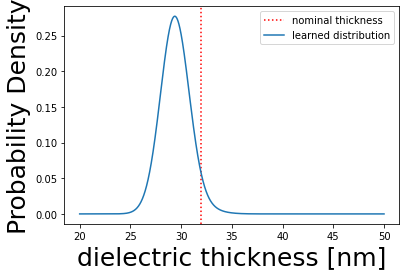

In [246]:
know_means = 26,26
know_stdevs = 2.23, 2.23
know_weights = 1, 1
know_x = np.arange(20., 50., 0.0001)
plt.axvline(x=32, ls=':', label='nominal thickness', color='red')
draw_gmm(means,stdevs, weights,know_x,label='learned distribution')
print(means)
print(learned_a)
print(learned_b)
# draw_gmm(know_means,know_stdevs, know_weights,know_x, label='Convolution-based Method')

## Data Generation (Sampling Latent Space)

In [ ]:
from reliability.Distributions import Weibull_Distribution
from reliability.Fitters import Fit_Weibull_Mixture
from reliability.Other_functions import histogram
# generate data
vae.eval()
with torch.no_grad():
  # Sample from standard normal distribution
  total_recon = []
  for j in range(200):
    gmm_mu = learned_mu1*learned_pi+learned_mu2*(1-learned_pi)
    recon_beta_list = []
    recon_t63_list = []
    reconstructions = []
    eps1 = torch.randn(batch_size, input_size)
    eps2 = torch.randn(batch_size, input_size)
    first_z = eps1.mul(torch.exp(0.5*(learned_logvar2))).add_(learned_mu1)
    second_z = eps2.mul(torch.exp(0.5*(learned_logvar2))).add_(learned_mu2)
    first_z = eps1.mul(torch.exp(0.5*(learned_logvar2))).add_(learned_mu1)
    second_z = eps2.mul(torch.exp(0.5*(learned_logvar2))).add_(learned_mu2)
    mixed_z = torch.tensor([])
    select = torch.rand(batch_size, 1)
    for i in range(batch_size):
      if select[i][0] < learned_pi:
        mixed_z = torch.cat((mixed_z, first_z[i]), 0)
      else:
        mixed_z = torch.cat((mixed_z, second_z[i]), 0)
    mixed_z = mixed_z.reshape(batch_size, input_size)
    ernest_z=eps1.mul(torch.exp(0.5*ernest_std)).add_(ernest_mean)
    for i in range(50):
      # eps = torch.randn(batch_size, input_size)
      # first_z = eps.mul(torch.exp(0.5*learned_logvar1)).add_(learned_mu1)
      # second_z = eps.mul(torch.exp(0.5*learned_logvar2)).add_(learned_mu2)
      # mixed_z = first_z.mul(learned_pi).add_(second_z.mul(1-learned_pi))
      # ernest_z=eps.mul(torch.exp(0.5*ernest_std)).add_(ernest_mean)
      if ernest == True:
        recon_beta, recon_t63 = vae.decoder(ernest_z.view(-1, input_size), ernest_a, ernest_b, ernest_mean, torch.tensor([generate_area, generate_area]))
      else:
        recon_beta, recon_t63 = vae.decoder(mixed_z.view(-1, input_size), learned_a, learned_b, gmm_mu, torch.tensor([generate_area, generate_area]))
      recon_beta_list+=recon_beta.numpy().flatten().tolist()
      recon_t63_list+=recon_t63.numpy().flatten().tolist()
    for i in range(len(recon_beta_list)):
      m = Weibull_Distribution(alpha=recon_t63_list[i], beta=recon_beta_list[i]).random_samples(1)
      reconstructions+=m.tolist()
      # Reconstruct images from sampled latent vectors
    total_recon.append(np.sort(np.array(reconstructions)))
  total_recon = np.array(total_recon)
  sidx = total_recon.argsort(axis=0)
  total_recon = total_recon[sidx, np.arange(sidx.shape[1])]
  left_bound = total_recon[0]
  right_bound = total_recon[199]
  left_bound_95 = total_recon[9]
  right_bound_95 = total_recon[189]
    

from reliability.Probability_plotting import Weibull_probability_plot
from reliability.Probability_plotting import plot_points
from reliability.Probability_plotting import plotting_positions
area1=np.sort(df.iloc[:area1_point,area_choose].values.flatten())
left_points = np.ones(round(len(reconstructions)*censor_percent/(1+censor_percent)))*(0.2)
uncensored_reconstruction=np.sort(np.concatenate((left_points, np.array(reconstructions))))
left_bound=np.concatenate((left_points,left_bound))
right_bound=np.concatenate((left_points,right_bound))
left_bound_95 = np.concatenate((left_points,left_bound_95))
right_bound_95 = np.concatenate((left_points,right_bound_95))
reconstruction_results= Weibull_probability_plot(failures=uncensored_reconstruction,show_fitted_distribution=False, color='red',show_scatter_points=False)
experiment_result= Weibull_probability_plot(failures=area1,show_fitted_distribution=False, show_scatter_points=False, color='blue')
# plot_points(failures=uncensored_reconstruction, color='red', marker='^', s=100)
plot_points(failures=area1, color='blue', marker='^', s=100)
left_x, left_y=plotting_positions(failures=left_bound_95)
right_x, right_y=plotting_positions(failures=right_bound_95)
plt.plot(left_x, left_y, c='dodgerblue', linewidth=5)
plt.plot(right_x, right_y, c='crimson', linewidth=5)

xfill = np.sort(np.concatenate([left_x, right_x]))
y1fill = np.interp(xfill, left_x, left_y)
y2fill = np.interp(xfill, right_x, right_y)
plt.fill_between(xfill, y1fill, y2fill, where=y1fill < y2fill, interpolate=True, color='dodgerblue', alpha=0.2)
plt.fill_between(xfill, y1fill, y2fill, where=y1fill > y2fill, interpolate=True, color='crimson', alpha=0.2)

plt.xlim(left=0.3)
plt.xlabel('Time [s]',fontdict = {'fontsize' : 25})
plt.ylabel('Fraction Failed',fontdict = {'fontsize' : 25})
plt.title('')
plt.legend('')
plt.show()

In [ ]:
experiment_result= Weibull_probability_plot(failures=area1,show_fitted_distribution=False, show_scatter_points=False, color='blue')

In [ ]:
print(torch.exp(0.5*learned_logvar1)*4)
print(torch.exp(0.5*learned_logvar1+1.38629))
eps = torch.randn(batch_size, input_size)
test1 = eps.mul(torch.exp(0.5*learned_logvar1)/4).add_(learned_mu1)*4
test2 = eps.mul(torch.exp(0.5*learned_logvar1)).add_(learned_mu1)
print(test1)
print(test2)
test_beta, test_t63 = vae.decoder(mixed_z.view(-1, input_size), learned_a, learned_b, gmm_mu, torch.tensor([generate_area, generate_area]))
print("test_beta: ", test_beta)
print("test_t63: ", test_t63)

In [ ]:
from reliability.Probability_plotting import Weibull_probability_plot
from reliability.Probability_plotting import plot_points
area1=df.iloc[:area1_point,1].values.flatten()
left_points = np.ones(round(len(reconstructions)*censor_percent/(1+censor_percent)))*(0.2)
uncensored_reconstruction=np.concatenate((left_points, np.array(reconstructions)))
reconstruction_results= Weibull_probability_plot(failures=uncensored_reconstruction,show_fitted_distribution=False, color='red',show_scatter_points=False)
experiment_result= Weibull_probability_plot(failures=area1, show_scatter_points=False, color='blue')
plot_points(failures=uncensored_reconstruction, color='red', marker='^', s=100)
plot_points(failures=area1, color='blue', marker='^', s=100)
plt.xlim(left=0.3)
plt.xlabel('Time [s]',fontdict = {'fontsize' : 25})
plt.ylabel('Fraction Failed',fontdict = {'fontsize' : 25})
plt.title('')
plt.legend('')
plt.show()

In [ ]:
temp1 = uncensored_reconstruction
temp2 = area1

In [ ]:
reconstruction_results= Weibull_probability_plot(failures=uncensored_reconstruction,show_fitted_distribution=False, color='red',show_scatter_points=False)
experiment_result= Weibull_probability_plot(failures=area1, show_scatter_points=False, color='orange')
reconstruction_results2= Weibull_probability_plot(failures=temp1,show_fitted_distribution=False, color='red',show_scatter_points=False)
experiment_result2= Weibull_probability_plot(failures=temp2, show_scatter_points=False, color='blue')
# plot_points(failures=uncensored_reconstruction, color='black', marker='^', s=100)
plot_points(failures=area1, color='orange', marker='^', s=100)
# plot_points(failures=temp1, color='red', marker='^', s=100)
plot_points(failures=temp2, color='blue', marker='^', s=100)
plt.xlim(left=0.3)
plt.xlabel('Time [s]',fontdict = {'fontsize' : 30})
plt.ylabel('Fraction Failed',fontdict = {'fontsize' : 30})
plt.title('')
plt.legend('')
plt.show()

## Display Latent Space
Here we can see what the latent space looks like by visualize a grid on it.

In [ ]:
with torch.no_grad():
  # Create empty (x, y) grid
  latent_x = np.linspace(-1.5, 1.5, 20)
  latent_y = np.linspace(-1.5, 1.5, 20)
  latents = torch.FloatTensor(len(latent_x), len(latent_y), latent_dim)
  # Fill up the grid
  for i, lx in enumerate(latent_x):
    for j, ly in enumerate(latent_y):
      latents[j, i, 0] = lx
      latents[j, i, 1] = ly
  # Flatten the grid
  latents = latents.view(-1, latent_dim)
  # Send to GPU
  latents = latents.to(device)
  # Find their representation
  reconstructions = vae.decoder(latents).reshape(-1, 1, 28,28)
  reconstructions = reconstructions.cpu()
  # Finally, plot
  fig, ax = plt.subplots(figsize=(10, 10))
  plt.imshow(np.transpose(make_grid(reconstructions.data[:400], 20, 5).clamp(0, 1).numpy(), (1, 2, 0))) 
